In [1]:



import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw
import popsims
from gala.units import UnitSystem
import pandas as pd
from scipy.interpolate import interp1d, griddata, InterpolatedUnivariateSpline
from astropy.io.votable import parse_single_table
import numba
plot_style()
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm import tqdm
#get_ipython().run_line_magic('matplotlib', 'inline')


# In[2]:
from popsims.plot_style import plot_style
plot_style()
from easyshapey import Box



path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'
path_bckgds= '../data/backgrounds/'
path_plot='../figures/'
isochrone_path=path_isochrone
from matplotlib import patches

In [2]:
mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']
#plt.style.use('dark_background') #f

In [3]:
#read strem
def read_stream_file(N_pal5, gap_center, box, rgc, mhalo, vhalo,    distance_to_hit =0.5):
    
    #filename='pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}'.format(rgc, mhalo, vhalo)
 
    #filename='pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}_distance_to_hit{}'.format(rgc, mhalo, vhalo, distance_to_hit )
    filename='no_self_grav_pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}_distance_to_hit{}'.format(rgc, mhalo, vhalo, distance_to_hit )
    st=(np.load(path_streamdata+'/{}.npy'.format(filename), allow_pickle=True).flatten()[0])['stream']
    
    x0=st.y.value
    y0=st.x.value

    center=np.nanmedian(np.array(rgc.split('_')).astype(float))

    #deptermine optimal rotation angle by fitting a line to the half stream
    mask= (x0-np.nanmedian(x0))>0.
    line = np.polyfit(x0[mask], y0[mask], 1)
    angle=np.arctan(line[0])
    x0, y0=rotate(x0, y0, -angle, c=(np.nanmedian(x0), np.nanmedian(y0)))

    xshift= np.nanmedian(x0)-center
    yshift=np.nanmedian(y0)-center

    x=x0-xshift
    y=y0-yshift

    xshift=gap_center[0]
    yshift=gap_center[1]

    x=x-xshift
    y=y-yshift
    
    choose=np.random.choice(np.arange(len(x)), N_pal5)
    
    return box.select(np.array([x[choose], y[choose]]))


def read_cmd_file(df, rgc, d_galaxy, mag_limit):
    d_m31= 770*u.kpc
    dmod_m31=5*np.log10(d_m31.to(u.pc).value/10.0)

    
    dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
    dmod_diff= dmod_galaxy-dmod_m31
    kpc_conversion = np.pi * d_galaxy / 180.
    
    #put to the desired distance modulus 
    mw_df= df.query("galaxy == 'MW'").reset_index(drop=True)
    m31_df= df.query("galaxy =='M31'").reset_index(drop=True)
    
    for k in ['appF062mag', 'appF087mag', 'appgmag', 'appimag']:
         m31_df[k]=  m31_df[k].values+dmod_diff
            
    #appply magnitude cut
    df_final=pd.concat([m31_df, mw_df]).reset_index(drop=True)
    df_final=(df_final[df_final.appF087mag < mag_limit]).reset_index(drop=True)
    
    
    #assign RA, DEC, xki based on the data
    from astropy.io.votable import parse_single_table
    data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
    
    
    for k in ['RA', 'Dec','xki', 'eta']:
        df_final[k]=np.random.choice(data[k].values, len(df_final), replace=True)
              
    
    s=SkyCoord(ra=df_final.RA, dec=df_final.Dec,frame = 'icrs', unit = (u.hourangle, u.deg))
    #s=SkyCoord(ra=df_final.RA, dec=df_final.Dec,frame = 'icrs', unit = (u.hourangle, u.deg))
    
    center=np.nanmedian(np.array(rgc.split('_')).astype(float))
    
    shift_x=np.nanmedian(kpc_conversion.value*(s.ra.to(u.degree).value))-center
    shift_y=np.nanmedian(kpc_conversion.value*(s.dec.to(u.degree).value))-center
    
    xs=kpc_conversion.value*(s.ra.to(u.degree).value)-shift_x
    ys=kpc_conversion.value*(s.dec.to(u.degree).value)-shift_y
    
    df_final['x_coord']=np.random.uniform(xs.min(), xs.max(), len(xs))
    df_final['y_coord']=np.random.uniform(ys.min(), ys.max(), len(ys))
    
    return df_final


def count_pal5_stars(mag_limit, dmod):
    dmod_pal5=16.85
    def read_pandas_isochrones():
        from astropy.io import ascii
        return ascii.read(path_isochrone+'/cfht_pre2014_isochrones_pal5.txt').to_pandas()

    def read_roman_isochrones():
        from astropy.io import ascii
        return ascii.read(path_isochrone+'/roman_isochrones_vega_pal5_3.7.txt').to_pandas()
    
    nsample=1e6
    masses= sample_from_powerlaw(-.5, xmin=0.1, xmax=10, nsample=nsample)
    cfht=read_pandas_isochrones()
    roman= read_roman_isochrones()
    comb= pd.concat([cfht, roman]).reset_index()
    
    
    isos={}
    for k in mag_keys:
        x= np.log10(comb.Mini.values)
        y=comb[k].values
        nans=np.logical_or(np.isnan(x), np.isnan(y))
        isos['mass']= masses
        #f=griddata(x[~nans], y[~nans], np.log10(masses) , fill_value=np.nan, method='linear', rescale=True)
        sort=np.argsort(x[~nans])
        f=interp1d(x[~nans][sort], y[~nans][sort], fill_value =np.nan, bounds_error=False)(np.log10(masses))
        isos.update({k: f+dmod_pal5})
    
    df=pd.DataFrame(isos)
    
    num_20_23= len(df.gmag.values[np.logical_and(df.gmag.values>=20, df.gmag.values<=23)])
    norm= (3000/num_20_23)
    
    #compute the difference between distance moduli and offset stars
    dist_mod_And = dmod- dmod_pal5
    
    return len(df.F087mag.values[df.F087mag.values<(mag_limit-dist_mod_And)])*norm


def make_box(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    return b

def rotate(x, y, ang, c=(0,0)):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

def make_an_image(d, rgc, mag_limit,  gap_center,  box_center, distance_to_hit=0.5, vhalo=-50, cut=False):
    mhalo=5e6
    fname=path_isochrone+'simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
    
    MASTER_DF=pd.read_csv(fname)
    #print (len(MASTER_DF))
    if cut:
        MASTER_DF=(MASTER_DF[MASTER_DF.MH<-1]).reset_index(drop=True)
    #print (len(MASTER_DF))
    d_galaxy=d*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)

    center=np.nanmedian(np.array(rgc.split('_')).astype(float))
    b=make_box( (center, center), roman_fov.value, roman_fov.value)

    dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
    N_pal5=int(count_pal5_stars(mag_limit, dmod_galaxy))
    vls=read_stream_file(N_pal5,gap_center, b, rgc, mhalo, vhalo,  distance_to_hit=distance_to_hit)

    bck=read_cmd_file(MASTER_DF, rgc, d_galaxy, mag_limit)
    s=b.select(bck[['x_coord', 'y_coord']])
    img= [np.concatenate([vls[0], s.x.values]), np.concatenate([vls[1], s.y.values])]
    
    return img, vls

In [10]:
mhalo=5e6
cent_values={'30_40': ((2.5, 0.1), (35.0, 35.2)), '10_20': ((2.5, 0.55), (15., 15)), '50_60': ((-4, .35),  (55, 55))}
distances_to_hit={'30_40': 0.7, '10_20':0.5, '50_60': 0.8}
vhalos={'10_20':20, '30_40':-50, '50_60':20}

In [11]:
rgc='30_40'
img= make_an_image(770, '30_40', 28.69,    cent_values[rgc][0], cent_values[rgc][1],  \
                      distance_to_hit=distances_to_hit[rgc], vhalo=vhalos[rgc], cut=True)

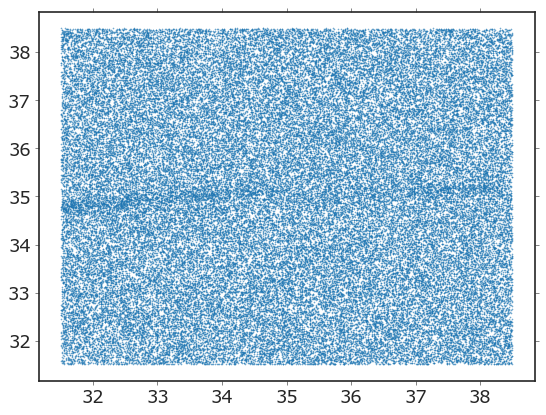

In [12]:
fig, ax=plt.subplots()
ax.scatter(img[0][0], img[0][1], s=0.1)

In [13]:
rgcs=['10_20', '30_40', '50_60']*2
mlimits=np.concatenate([[27.15]*3, [28.69]*3])

In [14]:
mlimits
d_galaxy=770*u.kpc
kpc_conversion = np.pi * d_galaxy / 180.
roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)
scaled_arcmin= 10*u.arcmin.to(u.degree)*(kpc_conversion /u.degree).value

In [15]:
REAL_IMAGES={'10_20':{},
            '30_40':{},
             '50_60':{}}


for  idx in range(0, 6):
    rgc=rgcs[idx]
    mlimit=mlimits[idx]
    img=make_an_image(770, rgc, mlimit,  cent_values[rgc][0], cent_values[rgc][1],  \
                      distance_to_hit=distances_to_hit[rgc], vhalo=vhalos[rgc], cut=True)
    REAL_IMAGES[rgc].update({mlimit: img})

FileNotFoundError: [Errno 2] No such file or directory: '../data/stream//no_self_grav_pal5_rgc10_20_mhalo5.00e+06_vhalo20_distance_to_hit0.5.npy'

In [ ]:
ms={'10_20': 0.0005,'30_40':0.005, '50_60': 0.005}

In [ ]:
fig, ax=plt.subplots(figsize=(12, 4*2), ncols=3, nrows=2)

for  idx in range(0, 6):
    a=np.concatenate(ax)[idx]
    rgc=rgcs[idx]
    mlimit=mlimits[idx]
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    img=REAL_IMAGES[rgc][mlimit]
    a.scatter(img[0][0], img[0][1], color='k', s=ms[rgc], alpha=0.5)

    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.set_title(' Rgc= {:.0f} kpc, Z = {} mag'.format(rgcx, mlimit), fontsize=14)
    a.set_xlabel('x (kpc)', fontsize=18)
    a.set_ylabel('y (kpc)', fontsize=18)
    
    #a.axis('equal')
    #a.axis('equal')
    rst=img[0]
    
   
    a.hlines(y=np.nanmin(rst[0])+1, xmin= np.nanmin( rst[0]), xmax=np.nanmin( rst[0])+scaled_arcmin, \
             linewidth=5, color='#FF851B')
    
    rect = patches.Rectangle( (np.nanmin( rst[0]), np.nanmin(rst[0])+1.1), \
                               3, 0.7, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')

    # Add the patch to the Axes
    a.add_patch(rect)
    a.text(np.nanmin( rst[0]), np.nanmin(rst[0])+1.3, '10 Arcmin',\
           color='#FF851B', alpha=1, fontsize=14, weight='bold')
    
    a.set(xlim=[rst[0].min(), rst[0].max()],
         ylim=[rst[0].min(), rst[0].max()])
    
    #a.scatter(rgcx-0.5,  rgcx+0.7, color='#0074D9', marker='$\u2193$', s=600)
    #a.scatter(rgcx-0.5,  rgcx+0.7, color='#0074D9', marker='$\u2193$', s=1000)
    a.text(rgcx-1.2,  rgcx+0.5, u'\u007d', fontsize=50, ha='left', va='bottom', rotation=90,  color='#FF851B')
    
    
    
    
    
    #print (dist)
    #a.
    #a.hlines(rgc-0.5, xmin=rgc-0.5-GAP_SIZES[dist]/2, \
    #         xmax=rgc-0.5+GAP_SIZES[dist]/2, color='b', linewidth=3 )
    a.minorticks_on()
    



plt.tight_layout()


plt.savefig(path_plot+'/gaps_at_M31_mhalo{:.2e}.jpeg'.format(mhalo))

In [ ]:
path_plot+'/gaps_at_M31_mhalo{:.2e}.jpeg'.format(mhalo)

In [ ]:
area=(7*u.kpc/(kpc_conversion/u.degree))**2
area

In [ ]:
for rgc in np.flip(['10_20', '30_40', '50_60']):
    img= img=REAL_IMAGES[rgc][28.69]
    print (rgc, len(img[0][0])/area/1e5)
    

In [ ]:
POLYNOMIAL_FITS={}

In [ ]:
for rgc in ['10_20', '30_40', '50_60']:
    center=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    b=make_box( (center, center), 15, 15)
    gap_center=cent_values[rgc][0]
    vhalo=-50
    vls=read_stream_file(int(1e4),gap_center, b, rgc, 5e6, -50, distance_to_hit= distances_to_hit[rgc])
    p=np.poly1d(np.polyfit(vls[0], vls[1], 2))
    xgrid= np.arange(center-7, center+7, 0.1)
    fig, ax=plt.subplots()
    ax.scatter(vls[0], vls[1], s=0.1)
    plt.plot(xgrid, p(xgrid), c='y')
    ax.set(xlim=[center-10, center+10], ylim=[center-10, center+10])
    print (p[rgcx])
    POLYNOMIAL_FITS.update({rgc: p})

In [ ]:
np.save('../data/polynomial_stream_paths.npy', POLYNOMIAL_FITS)

In [ ]:
(POLYNOMIAL_FITS['50_60'])(np.array([55, 56]))

In [ ]:
xgrid